In [1]:
%matplotlib inline

from astropy.io import fits as pyfits
from astropy.table import Table
import numpy as np
from astropy.io.fits import Column
from datetime import datetime
import matplotlib.pyplot as plt
import os
import warnings
import requests

In [2]:
def download_from_dropbox(url):
    
    local_filename = "{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [ ]:
# zeta parameters
zeta_fname = download_from_dropbox("https://www.dropbox.com/s/4xoryra28lxhlrm/zeta_parameters.fits?dl=1")
zeta_params=Table.read(zeta_fname)
slope = zeta_params['slope'][0]
intercept=zeta_params['intercept'][0]

In [6]:
#hubble_fname = download_from_dropbox("https://www.dropbox.com/s/dfmipz5jfzl9lja/input_for_hubble_debiased_catalog.fits?dl=1")
#internet slow, read from local for now. Future - dropbox link fine. 
hubble_fname = '/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/input_for_hubble_debiased_catalog.fits'

votes_data=Table.read(hubble_fname)

In [7]:
subjects=set(votes_data['zooniverse_id'])

In [8]:
#Zeta-hat function for computing debiased values
z0 = 0.3 # we're correcting to redshift 0.3

def fhat_mel(f,z,z0,zeta_hat):
    
    val = 1. - (1. - f)*np.exp(-(z - z0)/ zeta_hat)
    
    return val
#assume zeta_hat is a linear function of surface brightness
def zeta_hat_lin(SB):
    
    val = 10.**((SB*slope) + intercept)
    return val

In [29]:
## Split by table:


hubble = (votes_data['Table']=='hubble')
hubble_data = votes_data[hubble]

goods_shallow = (votes_data['Table']=='goods_shallow')
goods_shallow_data = votes_data[goods_shallow]

faded = (votes_data['Table']=='faded')
faded_data = votes_data[faded]

recoloured = (votes_data['Table']=='recoloured')
recoloured_data = votes_data[recoloured]

sdss_single = (votes_data['Table']=='sdss_single')
sdss_single = votes_data[sdss_single]

sdss_coadd = (votes_data['Table']=='sdss_coadd')
sdss_coadd = votes_data[sdss_coadd]

#fake AGN separate; they have extra data. Deal with later. 

In [24]:
#HUBBLE table

tablename = 'hubble'
data = hubble_data

subjects=set(data['zooniverse_id'])

intcolumn = np.zeros(len(subjects),dtype=int)
floatcolumn = np.zeros(len(subjects),dtype=float)
strcolumn = np.array([' ']*len(subjects),dtype='S24')

from astropy.table import Column as TableColumn
ex1 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_debiased_fraction', format='D')
ex2 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_lower_limit', format='D')
ex3 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_upper_limit', format='D')
ex4 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_best_fraction',format='D')
ex5 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_debiased_fraction', format='D')
ex6 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_best_fraction',format='D')
newtable = data.copy(copy_data=True)
newtable.add_columns( (ex1, ex2, ex3, ex4, ex5, ex6) )

#hubble; gets debiased
z = 'Z_BEST'
SB = 'GZ_MU_I'
print 'Writing file...'
for i,gal in enumerate(data):
    if i % 10000 == 0:
        t=datetime.now().time().isoformat()
        print 'Writing %ith row at time %s' %(i,t)
        
    #new data: debiased vote fractions
    p_features_debiased = fhat_mel(gal['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'],gal[z],z0,zeta_hat_lin(gal[SB]))
    newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i] = p_features_debiased
    
    #write the 'best features' fraction column 
    if newtable.field('correction_type')[i]==0: #correctable
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i]
    elif newtable.field('correction_type')[i]==1: #uncorrectable
        p_features_best = np.nanmax([newtable.field('t01_smooth_or_features_a02_features_or_disk_lower_limit')[i],newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]])
    else:
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]
    
    newtable.field('t01_smooth_or_features_a02_features_or_disk_best_fraction')[i] = p_features_best
    #debiased, lower and upper, best smooth fractions based on 1 - p_artifact - p_features
    newtable.field('t01_smooth_or_features_a01_smooth_debiased_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_debiased
    newtable.field('t01_smooth_or_features_a01_smooth_lower_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_upper_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_upper_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_lower_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_best_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_best

from datetime import datetime
#write to file 
#set path to file 
fname = '/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/catalog_%i_%i_%i_%s.fits'%(datetime.now().month,datetime.now().day,datetime.now().year,tablename)
newtable.write(fname,overwrite=True)    

Writing file...
Writing 0th row at time 00:53:15.939478
Writing 10000th row at time 00:53:27.547169
Writing 20000th row at time 00:53:38.676458
Writing 30000th row at time 00:53:49.518637
Writing 40000th row at time 00:54:00.424714
Writing 50000th row at time 00:54:11.235155
Writing 60000th row at time 00:54:22.061931
Writing 70000th row at time 00:54:32.848822
Writing 80000th row at time 00:54:43.630077
Writing 90000th row at time 00:54:54.421058
Writing 100000th row at time 00:55:05.199262
Writing 110000th row at time 00:55:16.029554


In [26]:
#Goods shallow table

tablename = 'goods_shallow'
data = goods_shallow_data

subjects=set(data['zooniverse_id'])

intcolumn = np.zeros(len(subjects),dtype=int)
floatcolumn = np.zeros(len(subjects),dtype=float)
strcolumn = np.array([' ']*len(subjects),dtype='S24')

from astropy.table import Column as TableColumn
ex1 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_debiased_fraction', format='D')
ex2 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_lower_limit', format='D')
ex3 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_upper_limit', format='D')
ex4 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_best_fraction',format='D')
ex5 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_debiased_fraction', format='D')
ex6 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_best_fraction',format='D')
newtable = data.copy(copy_data=True)
newtable.add_columns( (ex1, ex2, ex3, ex4, ex5, ex6) )

#goods shallow; gets debiased
z = 'Z_BEST'
SB = 'GZ_MU_I'
print 'Writing file...'
for i,gal in enumerate(data):
    if i % 10000 == 0:
        t=datetime.now().time().isoformat()
        print 'Writing %ith row at time %s' %(i,t)
        
    #new data: debiased vote fractions
    p_features_debiased = fhat_mel(gal['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'],gal[z],z0,zeta_hat_lin(gal[SB]))
    newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i] = p_features_debiased
    
    #write the 'best features' fraction column 
    if newtable.field('correction_type')[i]==0: #correctable
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i]
    elif newtable.field('correction_type')[i]==1: #uncorrectable
        p_features_best = np.nanmax([newtable.field('t01_smooth_or_features_a02_features_or_disk_lower_limit')[i],newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]])
    else:
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]
    
    newtable.field('t01_smooth_or_features_a02_features_or_disk_best_fraction')[i] = p_features_best
    #debiased, lower and upper, best smooth fractions based on 1 - p_artifact - p_features
    newtable.field('t01_smooth_or_features_a01_smooth_debiased_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_debiased
    newtable.field('t01_smooth_or_features_a01_smooth_lower_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_upper_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_upper_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_lower_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_best_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_best

from datetime import datetime
#write to file 
#set path to file 
fname = '/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/catalog_%i_%i_%i_%s.fits'%(datetime.now().month,datetime.now().day,datetime.now().year,tablename)
newtable.write(fname,overwrite=True)    

Writing file...
Writing 0th row at time 00:57:13.001655


In [27]:
#faded table

tablename = 'faded'
data = faded_data

subjects=set(data['zooniverse_id'])

intcolumn = np.zeros(len(subjects),dtype=int)
floatcolumn = np.zeros(len(subjects),dtype=float)
strcolumn = np.array([' ']*len(subjects),dtype='S24')

from astropy.table import Column as TableColumn
ex1 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_debiased_fraction', format='D')
ex2 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_lower_limit', format='D')
ex3 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_upper_limit', format='D')
ex4 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_best_fraction',format='D')
ex5 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_debiased_fraction', format='D')
ex6 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_best_fraction',format='D')
newtable = data.copy(copy_data=True)
newtable.add_columns( (ex1, ex2, ex3, ex4, ex5, ex6) )

#faded; gets debiased
z = 'Z_BEST'
SB = 'GZ_MU_I'
print 'Writing file...'
for i,gal in enumerate(data):
    if i % 10000 == 0:
        t=datetime.now().time().isoformat()
        print 'Writing %ith row at time %s' %(i,t)
        
    #new data: debiased vote fractions
    p_features_debiased = fhat_mel(gal['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'],gal[z],z0,zeta_hat_lin(gal[SB]))
    newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i] = p_features_debiased
    
    #write the 'best features' fraction column 
    if newtable.field('correction_type')[i]==0: #correctable
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i]
    elif newtable.field('correction_type')[i]==1: #uncorrectable
        p_features_best = np.nanmax([newtable.field('t01_smooth_or_features_a02_features_or_disk_lower_limit')[i],newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]])
    else:
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]
    
    newtable.field('t01_smooth_or_features_a02_features_or_disk_best_fraction')[i] = p_features_best
    #debiased, lower and upper, best smooth fractions based on 1 - p_artifact - p_features
    newtable.field('t01_smooth_or_features_a01_smooth_debiased_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_debiased
    newtable.field('t01_smooth_or_features_a01_smooth_lower_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_upper_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_upper_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_lower_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_best_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_best

from datetime import datetime
#write to file 
#set path to file 
fname = '/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/catalog_%i_%i_%i_%s.fits'%(datetime.now().month,datetime.now().day,datetime.now().year,tablename)
newtable.write(fname,overwrite=True)    

Writing file...
Writing 0th row at time 00:58:08.360931


In [30]:
#recoloured table

tablename = 'recoloured'
data = recoloured_data

subjects=set(data['zooniverse_id'])

intcolumn = np.zeros(len(subjects),dtype=int)
floatcolumn = np.zeros(len(subjects),dtype=float)
strcolumn = np.array([' ']*len(subjects),dtype='S24')

from astropy.table import Column as TableColumn
ex1 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_debiased_fraction', format='D')
ex2 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_lower_limit', format='D')
ex3 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_upper_limit', format='D')
ex4 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_best_fraction',format='D')
ex5 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_debiased_fraction', format='D')
ex6 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_best_fraction',format='D')
newtable = data.copy(copy_data=True)
newtable.add_columns( (ex1, ex2, ex3, ex4, ex5, ex6) )

#recoloured; gets debiased
z = 'Z_BEST'
SB = 'GZ_MU_I'
print 'Writing file...'
for i,gal in enumerate(data):
    if i % 10000 == 0:
        t=datetime.now().time().isoformat()
        print 'Writing %ith row at time %s' %(i,t)
        
    #new data: debiased vote fractions
    p_features_debiased = fhat_mel(gal['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'],gal[z],z0,zeta_hat_lin(gal[SB]))
    newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i] = p_features_debiased
    
    #write the 'best features' fraction column 
    if newtable.field('correction_type')[i]==0: #correctable
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i]
    elif newtable.field('correction_type')[i]==1: #uncorrectable
        p_features_best = np.nanmax([newtable.field('t01_smooth_or_features_a02_features_or_disk_lower_limit')[i],newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]])
    else:
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]
    
    newtable.field('t01_smooth_or_features_a02_features_or_disk_best_fraction')[i] = p_features_best
    #debiased, lower and upper, best smooth fractions based on 1 - p_artifact - p_features
    newtable.field('t01_smooth_or_features_a01_smooth_debiased_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_debiased
    newtable.field('t01_smooth_or_features_a01_smooth_lower_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_upper_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_upper_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_lower_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_best_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_best

from datetime import datetime
#write to file 
#set path to file 
fname = '/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/catalog_%i_%i_%i_%s.fits'%(datetime.now().month,datetime.now().day,datetime.now().year,tablename)
newtable.write(fname,overwrite=True)    

Writing file...
Writing 0th row at time 01:00:07.804149


In [31]:
#check corrections in hubble table

correctable=(hubble_data['correction_type']==0)
uncorrectable=(hubble_data['correction_type']==1)
nei=(hubble_data['correction_type']==3)

old_votes=hubble_data['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
old_z=hubble_data[z]
old_mu=hubble_data[SB]

new_c=fhat_mel(old_votes[correctable],old_z[correctable],z0,zeta_hat_lin(old_mu[correctable]))
new_unc=fhat_mel(old_votes[uncorrectable],old_z[uncorrectable],z0,zeta_hat_lin(old_mu[uncorrectable])) #debiased value
#new_unc = old_lower_limit[uncorrectable] #lower limit
new_nei=fhat_mel(old_votes[nei],old_z[nei],z0,zeta_hat_lin(old_mu[nei]))

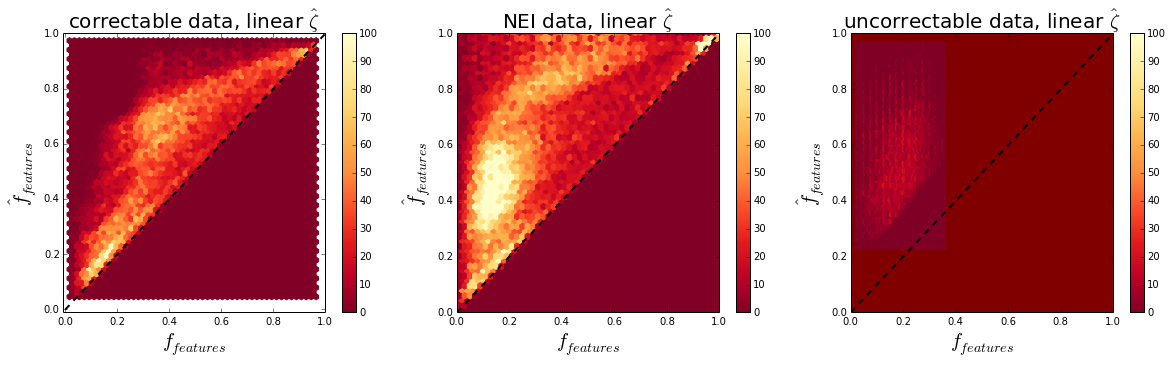

In [32]:
# 2D histogram of new p_features distribution
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(131)
hex1 = ax1.hexbin(old_votes[correctable],new_c, cmap=plt.cm.YlOrRd_r,gridsize=50,vmin =0,vmax=100)
ax1.set_xlabel(r'$f_{features}$',fontsize=20)
ax1.set_ylabel(r'$\hat f_{features}$',fontsize=20)
cb1 = plt.colorbar(hex1)
ax1.set_title('correctable data, linear $\hat \zeta$',fontsize=20)

# Add the one-to-one line for comparision.
# Upper left = boosted p_features for z > 0.3
# Lower right = depressed p_features for z < 0.3

ax1.plot([0,1],[0,1],color='k',lw=2,ls='--')

# Try it with Mel's new function
ax2 = fig.add_subplot(132)
hex2 = ax2.hexbin(old_votes[nei],new_nei, cmap=plt.cm.YlOrRd_r,gridsize=50,vmax=100)
ax2.set_xlabel(r'$f_{features}$',fontsize=20)
ax2.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
cb2 = plt.colorbar(hex2)
ax2.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax2.set_title('NEI data, linear $\hat \zeta$',fontsize=20)

ax3 = fig.add_subplot(133)
hex3 = ax3.hexbin(old_votes[uncorrectable],new_unc, cmap=plt.cm.YlOrRd_r,gridsize=50,vmin =0, vmax=100)
ax3.set_xlabel(r'$f_{features}$',fontsize=20)
ax3.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
cb3 = plt.colorbar(hex3)
ax3.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax3.set_title('uncorrectable data, linear $\hat \zeta$',fontsize=20)
ax3.set_axis_bgcolor('#800000')

